In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['pdf.fonttype'] = 42

In [2]:
df = pd.read_csv('data/received.csv')
df_sent = pd.read_csv('data/sent.csv')

In [3]:
df.index = pd.to_datetime(df.Timestamp)

In [4]:
del df['Timestamp']

In [5]:
df.fillna('', inplace=True)

In [6]:
df_sent.index = pd.to_datetime(df_sent.Timestamp)
del df_sent['Timestamp']

## 1. Tri des e-mails par étiquette, expéditeur, destinataire

In [7]:
spam = df.Label.str.contains('Spam')
sent = df.Label.str.contains('Messages envoyés')
inbox = df.Label.str.contains('Boîte de réception')
replies = df['Subject'].str.contains('Re:|RE:|RE|AW:')

# A adapter selon vos étiquettes - sera vide sinon
a_moi = df['Label'].str.contains('A moi')
me_list = df[a_moi]['To'].value_counts().head(10).index.tolist()
me_only = df['To'].isin(me_list)
interne = df['From'].str.contains('tdg|newsnetz|24heures|agencesportcenter.ch|mg.tcch.ch|wetransfer.com')
me_cc = df['Cc'].str.contains('Ronga|ronga')

In [8]:
# Pour être sûr. Ils doivent être dans sent.csv
df[sent]

,Cc,Date,From,Label,Spam,Subject,To
Timestamp,,,,,,,


In [9]:
# Test d'une expression régulière pour les adresses entre < … >

_from = df['From'].values[0] + ' dada'
match = re.match('.*\<(.*)\>', _from)
print(match.group(1))

info@mail5.ch-maildb.net


In [10]:
# cette fonction renvoie le domaine (par exemple tdg.ch) d’où l'e-mail a été envoyé

def getTopDomain(_from):
    if _from.find('<') >= 0:
        match = re.match('.*\<(.*)\>', _from)
        if match:
            return match.group(1).split('@')[-1]
        if not match:
            return False
        return True
    else:
        return _from.split('@')[-1]

df['From Domain'] = df['From'].apply(getTopDomain)
df['To Domain'] = df['To'].apply(getTopDomain)
df['Cc Domain'] = df['Cc'].apply(getTopDomain)
# Décommenter pour voir le résultat
# df['Domain'].value_counts().head(40)

In [11]:
df['From Domain'] = df['From Domain'].apply(lambda x: x.replace('sr.', ''))
df['To Domain'] = df['To Domain'].apply(lambda x: x.replace('sr.', ''))
df['Cc Domain'] = df['Cc Domain'].apply(lambda x: x.replace('sr.', ''))

### Combien d’e-mails ont les principales étiquettes?

In [12]:
df.shape

(4198, 10)

In [13]:
df[inbox].shape

(496, 10)

In [14]:
df[spam].shape

(694, 10)

In [15]:
df[me_only].shape

(368, 10)

In [16]:
df[-me_only & -spam].shape

(3142, 10)

In [17]:
df[replies].shape

(533, 10)

# 2. Résultats en chiffres

#### Pertinents vs non pertinent

In [18]:
print(len(df[inbox]), 'messages dans l’inbox sur', len(df))
print(len(df[inbox & -spam]) / len(df[-spam]) * 100, '%')
print(len(df[-inbox & -spam]) / len(df[-spam]) * 100, '%')
print(len(df[-inbox & -spam]), 'inutiles sur', len(df[-spam]), '(hors spam)')

496 messages dans l’inbox sur 4198
14.15525114155251 %
85.84474885844749 %
3008 inutiles sur 3504 (hors spam)


#### Interne / externe

In [19]:
len(df[-inbox & interne & -spam]), len(df[-inbox & -interne & -spam])

(1307, 1701)

#### Réponses et Cc

In [20]:
len(df[-inbox & replies & -spam])

199

In [21]:
len(df[-inbox & (df['Cc'] != '') & -spam])

383

#### Cc et groupes de distribution

In [22]:
len(df[-inbox & -spam]), len(df[-inbox & (df['Cc'] != '') & -spam])

(3008, 383)

In [23]:
df[interne & -inbox & -spam & (df['Cc'] == '')].shape

(1201, 10)

In [24]:
df[-inbox & interne & (df['Cc'] != '')].shape

(106, 10)

In [25]:
df[-inbox & -spam]['To Domain'].value_counts().head()

tdg.ch         1529
tamedia.ch      520
                195
None            179
24heures.ch     157
Name: To Domain, dtype: int64

In [26]:
df[-inbox & -spam]['Cc Domain'].value_counts().head()

                      2625
20minutes.ch           191
tdg.ch                  78
tamedia.ch              31
lematindimanche.ch      14
Name: Cc Domain, dtype: int64

In [27]:
df[-inbox & -spam]['To'].value_counts().head()

TG Web <tg.web@sr.tamedia.ch>    240
blog@tdg.ch                      228
                                 195
None                             179
news@tdg.ch                      177
Name: To, dtype: int64

In [28]:
df_intern = df[-inbox & -spam & interne].copy()

In [29]:
df_intern.shape

(1307, 10)

In [30]:
df_intern[df_intern['To'].str.contains('Web|web') | df_intern['Cc'].str.contains('Web|web')].shape

(952, 10)

## Heures d’envoi

In [31]:
# 0h - 23h
pd.options.display.max_columns = 24
pd.DataFrame(df[-spam].groupby(df[-spam].index.hour)['To'].count()).transpose()

Timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
To,16,7,4,6,6,68,142,198,265,329,285,153,159,245,294,325,307,263,148,94,72,58,49,11


In [32]:
# idem, messages internes non pertinents
target_df = df[-inbox & interne & -spam]
pd.DataFrame(target_df.groupby(target_df.index.hour)['To'].count()).transpose()

Timestamp,1,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
To,2,1,1,57,98,80,105,82,35,45,80,116,135,145,128,73,35,36,29,22,2


In [33]:
# externes non pertinents
target_df = df[-inbox & -interne & -spam]
pd.DataFrame(target_df.groupby(target_df.index.hour)['To'].count()).transpose()

Timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
To,15,5,4,4,4,66,75,84,136,186,157,95,88,123,127,139,115,103,67,43,24,15,18,8


In [34]:
# les miens
pd.DataFrame(df_sent.groupby(df_sent.index.hour)['To'].count()).transpose()

Timestamp,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
To,1,11,43,30,29,14,14,36,30,38,41,38,9,2,5,2,2


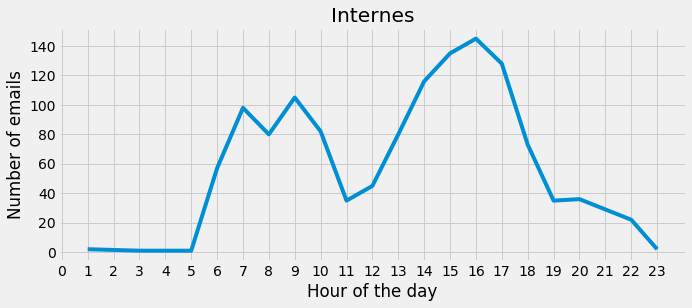

In [40]:
ax = plt.subplot()

dft = df[-spam & -inbox & interne].copy()
dft.groupby(dft.index.hour)['To'].count().plot(figsize=(10, 4), title="Internes")
plt.ylabel('Number of emails')
plt.xlabel('Hour of the day')
ax.set_xticks(range(0, 24, 1))
print()

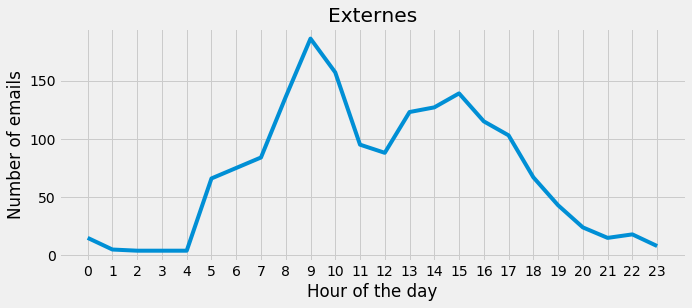

In [41]:
ax = plt.subplot()

dft = df[-spam & -inbox & -interne].copy()
dft.groupby(dft.index.hour)['To'].count().plot(figsize=(10, 4), title="Externes")
plt.ylabel('Number of emails')
plt.xlabel('Hour of the day')
ax.set_xticks(range(0, 24, 1))
print()



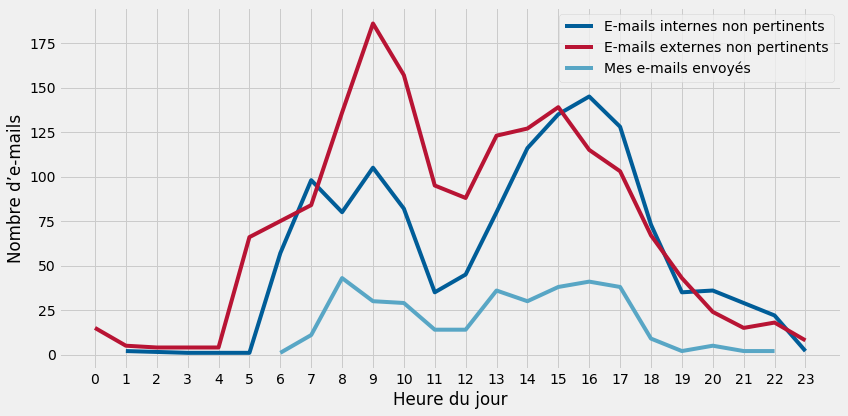

In [42]:
ax = plt.subplot()

#dft = df[-spam & -inbox].copy()
df[-spam & -inbox & interne].groupby(df[-spam & -inbox & interne].index.hour)['To'].count().plot(figsize=(12, 6), c='#005d98', label='E-mails internes non pertinents')
df[-spam & -inbox & -interne].groupby(df[-spam & -inbox & -interne].index.hour)['To'].count().plot(figsize=(12, 6), c='#b81434', label='E-mails externes non pertinents')
df_sent.groupby(df_sent.index.hour)['To'].count().plot(figsize=(12, 6), c='#58a6c5', label='Mes e-mails envoyés')

plt.ylabel('Nombre d’e-mails')
plt.xlabel('Heure du jour')
ax.set_xticks(range(0, 24, 1))
plt.legend()
plt.tight_layout()
plt.savefig('e-mails.pdf')
print()


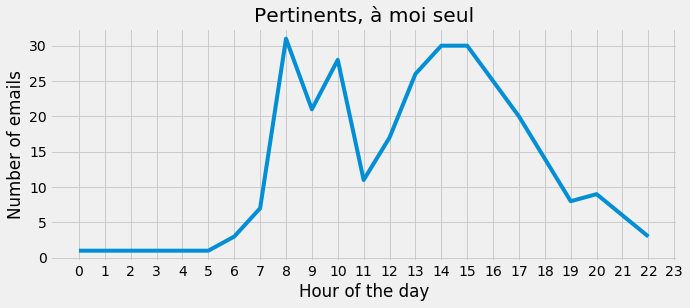

In [43]:
ax = plt.subplot()

dft = df[me_only & inbox & -spam].copy()
dft.groupby(dft.index.hour)['To'].count().plot(figsize=(10, 4), title="Pertinents, à moi seul")
plt.ylabel('Number of emails')
plt.xlabel('Hour of the day')
ax.set_xticks(range(0, 24, 1))
print()



Text(0.5,0,'Hour of the day')

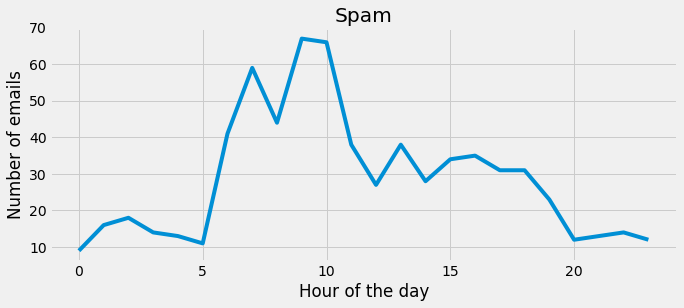

In [45]:
dft = df[spam].copy()
dft.groupby(dft.index.hour)['To'].count().plot(figsize=(10, 4), title='Spam')
plt.ylabel('Number of emails')
plt.xlabel('Hour of the day')

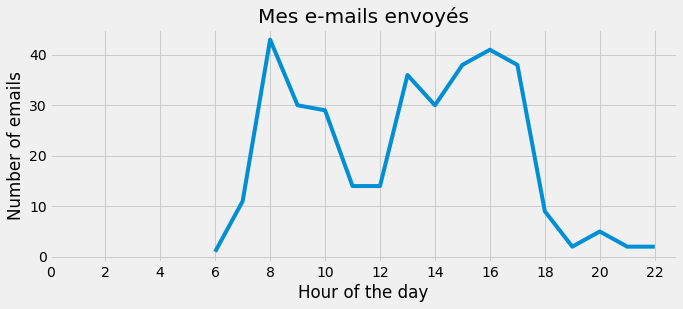

In [46]:
dft = df[sent].copy()
ax = plt.subplot()

df_sent.groupby(df_sent.index.hour)['To'].count().plot(figsize=(10, 4), title='Mes e-mails envoyés')
plt.ylabel('Number of emails')
plt.xlabel('Hour of the day')
ax.set_xticks(range(0, 24, 2))
print()